In [1]:
!pip install opendatasets

In [2]:
## Loading the dataset

import opendatasets as dataset

dataset.download('https://www.kaggle.com/datasets/dmitrybabko/speech-emotion-recognition-en/data', data_dir='datasets/')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: prashantkrmali
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/dmitrybabko/speech-emotion-recognition-en


100%|██████████| 987M/987M [00:13<00:00, 77.3MB/s]


## **1. Brief Information about the dataset**

### **About Dataset**

**Context**

Speech is the most natural way of expressing ourselves as humans. It is only natural then to extend this communication medium to computer applications. We define speech emotion recognition (SER) systems as a collection of methodologies that process and classify speech signals to detect the embedded emotions. SER is not a new field, it has been around for over two decades, and has regained attention thanks to the recent advancements. These novel studies make use of the advances in all fields of computing and technology, making it necessary to have an update on the current methodologies and techniques that make SER possible. We have identified and discussed distinct areas of SER, provided a detailed survey of current literature of each, and also listed the current challenges.

**Content**

Here 4 most popular datasets in English: Crema, Ravdess, Savee and Tess. Each of them contains audio in .wav format with some main labels.

1. `**Ravdess:**`

*Here is the filename identifiers as per the official RAVDESS website:*

>* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
>* Vocal channel (01 = speech, 02 = song).
>* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
>* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
>* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
>* Repetition (01 = 1st repetition, 02 = 2nd repetition).
>* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

*So, here's an example of an audio filename. 02-01-06-01-02-01-12.wav This means the meta data for the audio file is:*

>* Video-only (02)
>* Speech (01)
>* Fearful (06)
>* Normal intensity (01)
>* Statement "dogs" (02)
>* 1st Repetition (01)
>* 12th Actor (12) - Female (as the actor ID number is even)

2. `**Crema:**`

*The third component is responsible for the emotion label:*

>* SAD - sadness;
>* ANG - angry;
>* DIS - disgust;
>* FEA - fear;
>* HAP - happy;
>* NEU - neutral.

3. `**Tess:**`

*Very similar to Crema - label of emotion is contained in the name of file.*

4. `**Savee:**`

*The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:*

>* 'a' = 'anger'
>* 'd' = 'disgust'
>* 'f' = 'fear'
>* 'h' = 'happiness'
>* 'n' = 'neutral'
>* 'sa' = 'sadness'
>* 'su' = 'surprise'

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

# to play the audio file
from IPython.display import Audio

from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from collections.abc import Iterable

from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, BatchNormalization
from keras import layers, callbacks

sns.set(style='darkgrid', color_codes=True)

In [5]:
## Root directory

root_dir = '/content/datasets/speech-emotion-recognition-en/'

## Paths to Crema, Ravdees, Savee & Tess

Crema_path = root_dir + "/Crema/"
Ravdess_path = root_dir + "/Ravdess/audio_speech_actors_01-24/"
Savee_path = root_dir + "/Savee/"
Tess_path = root_dir + "/Tess/"

In [6]:
Crema_dir_list = os.listdir(Crema_path)
Ravdess_dir_list = os.listdir(Ravdess_path)
Savee_dir_list = os.listdir(Savee_path)
Tess_dir_list = os.listdir(Tess_path)

In [7]:
len(Crema_dir_list), len(Ravdess_dir_list), len(Savee_dir_list), len(Tess_dir_list)

(7442, 24, 480, 14)

In [8]:
print("Total number of files: ", sum([len(Crema_dir_list), len(Ravdess_dir_list), len(Savee_dir_list), len(Tess_dir_list)]))

Total number of files:  7960


## 2. Data Preprocessing

### 2.1 Crema

In [9]:
Crema_dir_list[:15]

['1013_IEO_FEA_LO.wav',
 '1021_WSI_DIS_XX.wav',
 '1088_TAI_DIS_XX.wav',
 '1074_IEO_ANG_LO.wav',
 '1039_IWL_NEU_XX.wav',
 '1062_IWL_SAD_XX.wav',
 '1005_WSI_DIS_XX.wav',
 '1082_TSI_HAP_XX.wav',
 '1073_IEO_HAP_HI.wav',
 '1062_WSI_DIS_XX.wav',
 '1007_IOM_SAD_XX.wav',
 '1010_ITS_SAD_XX.wav',
 '1006_IWW_NEU_XX.wav',
 '1062_IEO_FEA_LO.wav',
 '1026_ITH_DIS_XX.wav']

In [10]:
%%time

emotions_crema = []
paths_crema = []

for file in Crema_dir_list:
  ## storing the paths
  paths_crema.append(Crema_path + file)

  ## storing file emotions
  emotion = file.split('_')[2]

  if emotion == 'SAD':
    emotions_crema.append('sad')
  elif emotion == 'ANG':
    emotions_crema.append('angry')
  elif emotion == 'DIS':
    emotions_crema.append('disgust')
  elif emotion == 'FEA':
    emotions_crema.append('fear')
  elif emotion == 'HAP':
    emotions_crema.append('happy')
  elif emotion == 'NEU':
    emotions_crema.append('neutral')
  else:
    emotions_crema.append('unknown')


## Creating dataframe for Crema

crema_df = pd.DataFrame(list(zip(paths_crema, emotions_crema)), columns=['path', 'emotion'])
print(crema_df.shape)
crema_df.head(15)

(7442, 2)
CPU times: user 12.9 ms, sys: 1.86 ms, total: 14.7 ms
Wall time: 22.9 ms


path  emotion
0   /content/datasets/speech-emotion-recognition-e...     fear
1   /content/datasets/speech-emotion-recognition-e...  disgust
2   /content/datasets/speech-emotion-recognition-e...  disgust
3   /content/datasets/speech-emotion-recognition-e...    angry
4   /content/datasets/speech-emotion-recognition-e...  neutral
5   /content/datasets/speech-emotion-recognition-e...      sad
6   /content/datasets/speech-emotion-recognition-e...  disgust
7   /content/datasets/speech-emotion-recognition-e...    happy
8   /content/datasets/speech-emotion-recognition-e...    happy
9   /content/datasets/speech-emotion-recognition-e...  disgust
10  /content/datasets/speech-emotion-recognition-e...      sad
11  /content/datasets/speech-emotion-recognition-e...      sad
12  /content/datasets/speech-emotion-recognition-e...  neutral
13  /content/datasets/speech-emotion-recognition-e...     fear
14  /content/datasets/speech-emotion-recognition-e...  disgust

In [11]:
## Creating a function to vizualize the emotion count & its distribution using Horizontal Bar & Pie graph

def vizualise_emotion(df):
  sns.set(style='darkgrid', color_codes=True)

  # Calculate value counts and percentages
  category_counts = df['emotion'].value_counts()
  labels = category_counts.index
  sizes = category_counts.values
  percentages = sizes / sum(sizes) * 100

  # Define colors for pie chart segments
  colors = sns.color_palette('pastel')[0:len(labels)]

  # Create a figure with two subplots
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

  # Horizontal bar chart (countplot)
  sns.countplot(y='emotion', data=df, palette='crest', ax=ax1)
  for i in range(len(category_counts)):
    ax1.bar_label(ax1.containers[i],fontsize=14,label_type='edge')
  ax1.set_title('Count of Emotions')
  ax1.set_xlabel('Count')
  ax1.set_ylabel('Types of Emotions')

  # Pie chart
  ax2.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops={'edgecolor': 'white'}, )
  ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  ax2.set_title('Percentage Distribution of Emotions')

  # Adjust layout
  plt.tight_layout()

  # Show plot
  plt.show()

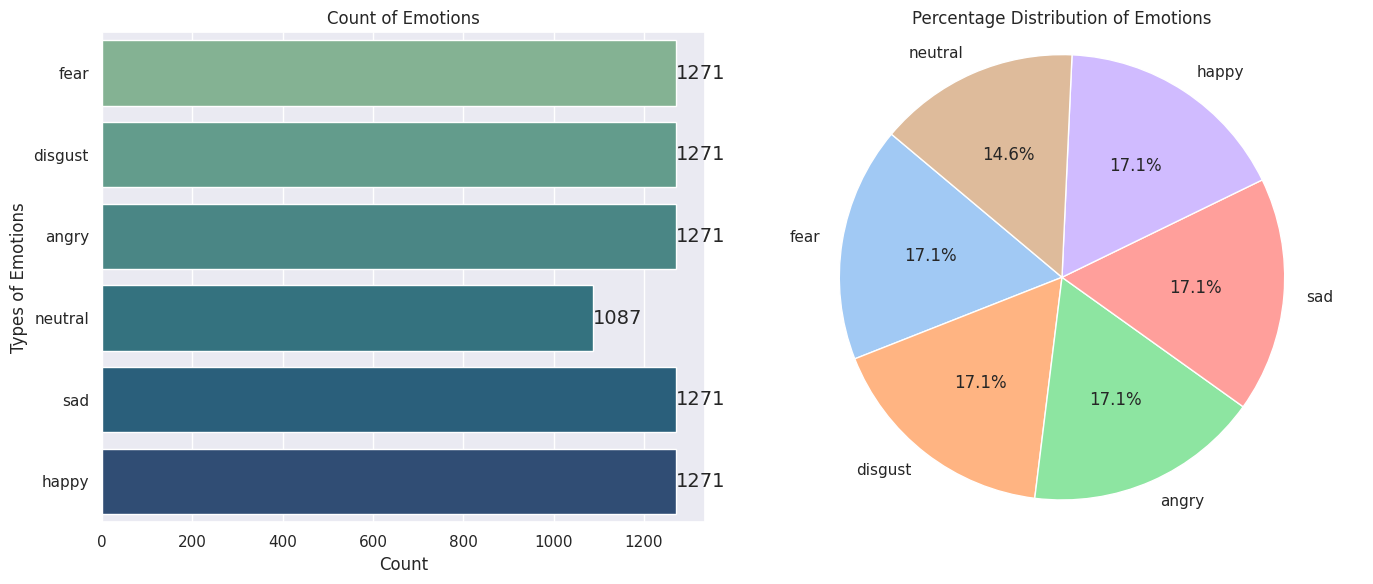

In [12]:
## Vizualizing the Crema data

vizualise_emotion(crema_df)

### 2.2 Ravdees

In [13]:
## Checking the length of Ravdees dir
len(Ravdess_dir_list)

24

In [14]:
emotions_ravdees = []
path_ravdees = []

for item in Ravdess_dir_list:
  ## There are 24 actors
  actor = os.listdir(Ravdess_path + item + '/')

  ## gathering emotions from the file name
  for file in actor:
    file_path = Ravdess_path + item + '/' + file
    part = file.split('.')[0]
    emotion = part.split('-')[2]

    ## appending paths
    path_ravdees.append(file_path)

    ## third part in each file represents the emotion associated to that file.

    ## 01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised

    if emotion == '01':
      emotions_ravdees.append('neutral')
    elif emotion == '02':
      emotions_ravdees.append('neutral') ## reducing the categories in the dataset replacing 'calm' -> 'neutral'
    elif emotion == '03':
      emotions_ravdees.append('happy')
    elif emotion == '04':
      emotions_ravdees.append('sad')
    elif emotion == '05':
      emotions_ravdees.append('angry')
    elif emotion == '06':
      emotions_ravdees.append('fearful')
    elif emotion == '07':
      emotions_ravdees.append('disgust')
    elif emotion == '08':
      emotions_ravdees.append('surprised')
    else:
      emotions_ravdees.append('unknown')


## Create dataframe for Ravdees

ravdees_df = pd.DataFrame(list(zip(path_ravdees, emotions_ravdees)), columns=['path', 'emotion'])
print(ravdees_df.shape)
ravdees_df.head(15)

(1440, 2)


path    emotion
0   /content/datasets/speech-emotion-recognition-e...        sad
1   /content/datasets/speech-emotion-recognition-e...    neutral
2   /content/datasets/speech-emotion-recognition-e...      angry
3   /content/datasets/speech-emotion-recognition-e...    neutral
4   /content/datasets/speech-emotion-recognition-e...      angry
5   /content/datasets/speech-emotion-recognition-e...        sad
6   /content/datasets/speech-emotion-recognition-e...  surprised
7   /content/datasets/speech-emotion-recognition-e...    neutral
8   /content/datasets/speech-emotion-recognition-e...    neutral
9   /content/datasets/speech-emotion-recognition-e...      happy
10  /content/datasets/speech-emotion-recognition-e...      happy
11  /content/datasets/speech-emotion-recognition-e...  surprised
12  /content/datasets/speech-emotion-recognition-e...      happy
13  /content/datasets/speech-emotion-recognition-e...    neutral
14  /content/datasets/speech-emotion-recognition-e...    neutral

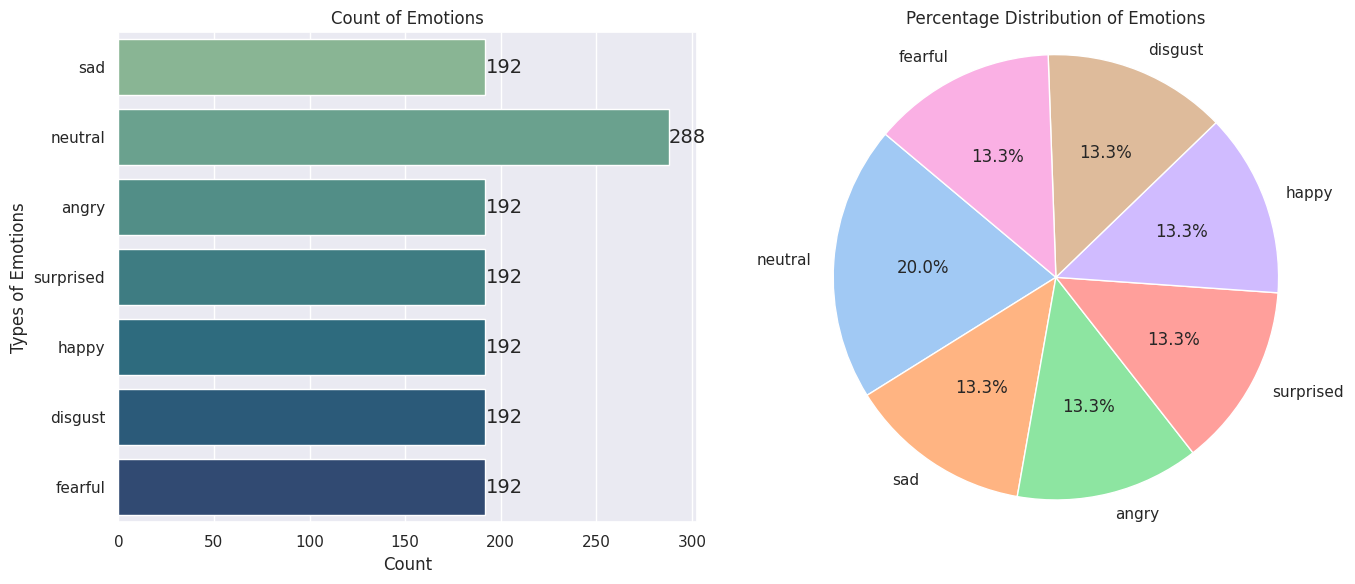

In [15]:
## Vizualizing the Ravdess dataset

vizualise_emotion(ravdees_df)

#### 2.3 Savee

In [16]:
Savee_dir_list[:15]

['JK_su15.wav',
 'DC_h03.wav',
 'KL_n10.wav',
 'KL_d13.wav',
 'KL_f03.wav',
 'KL_f01.wav',
 'DC_n04.wav',
 'KL_n01.wav',
 'DC_d03.wav',
 'JK_n01.wav',
 'DC_a01.wav',
 'DC_f11.wav',
 'KL_f11.wav',
 'DC_d09.wav',
 'JK_sa14.wav']

In [17]:
emotions_savee = []
path_savee = []

for it in Savee_dir_list:
    path_savee.append(Savee_path + it)
    part = it.split('_')[1]
    part = part[:-6]
    if part == 'a':
        emotions_savee.append('angry')
    elif part == 'd':
        emotions_savee.append('disgust')
    elif part == 'f':
        emotions_savee.append('fear')
    elif part == 'h':
        emotions_savee.append('happiness')
    elif part == 'n':
        emotions_savee.append('neutral')
    elif part == 'sa':
        emotions_savee.append('sadness')
    elif part == 'su':
        emotions_savee.append('surprise')

    else:
        emotions_savee.append('Unknown')


## Creating the dataset

savee_df = pd.DataFrame(list(zip(path_savee, emotions_savee)), columns=['path', 'emotion'])
print(savee_df.shape)
savee_df.head(15)

(480, 2)


path    emotion
0   /content/datasets/speech-emotion-recognition-e...   surprise
1   /content/datasets/speech-emotion-recognition-e...  happiness
2   /content/datasets/speech-emotion-recognition-e...    neutral
3   /content/datasets/speech-emotion-recognition-e...    disgust
4   /content/datasets/speech-emotion-recognition-e...       fear
5   /content/datasets/speech-emotion-recognition-e...       fear
6   /content/datasets/speech-emotion-recognition-e...    neutral
7   /content/datasets/speech-emotion-recognition-e...    neutral
8   /content/datasets/speech-emotion-recognition-e...    disgust
9   /content/datasets/speech-emotion-recognition-e...    neutral
10  /content/datasets/speech-emotion-recognition-e...      angry
11  /content/datasets/speech-emotion-recognition-e...       fear
12  /content/datasets/speech-emotion-recognition-e...       fear
13  /content/datasets/speech-emotion-recognition-e...    disgust
14  /content/datasets/speech-emotion-recognition-e...    sadness

In [18]:
## Visualizing the Savee Data

vizualise_emotion(savee_df)

#### 2.4 Tess

In [19]:
Tess_dir_list[:15]

['YAF_disgust',
 'OAF_neutral',
 'YAF_pleasant_surprised',
 'OAF_Sad',
 'YAF_sad',
 'OAF_disgust',
 'OAF_Fear',
 'OAF_angry',
 'OAF_Pleasant_surprise',
 'OAF_happy',
 'YAF_happy',
 'YAF_angry',
 'YAF_fear',
 'YAF_neutral']

In [20]:
len(Tess_dir_list)

14

In [21]:
emotions_tess = []
path_tess = []

for it in Tess_dir_list:
    directories = os.listdir(Tess_path + '/' + it)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            emotions_tess.append('surprise')
        else:
            emotions_tess.append(part)
        path_tess.append(Tess_path + it + '/' + file)


## Creating the dataset

tess_df = pd.DataFrame(list(zip(path_tess, emotions_tess)), columns=['path', 'emotion'])
print(tess_df.shape)
tess_df.head(15)

(2800, 2)


path  emotion
0   /content/datasets/speech-emotion-recognition-e...  disgust
1   /content/datasets/speech-emotion-recognition-e...  disgust
2   /content/datasets/speech-emotion-recognition-e...  disgust
3   /content/datasets/speech-emotion-recognition-e...  disgust
4   /content/datasets/speech-emotion-recognition-e...  disgust
5   /content/datasets/speech-emotion-recognition-e...  disgust
6   /content/datasets/speech-emotion-recognition-e...  disgust
7   /content/datasets/speech-emotion-recognition-e...  disgust
8   /content/datasets/speech-emotion-recognition-e...  disgust
9   /content/datasets/speech-emotion-recognition-e...  disgust
10  /content/datasets/speech-emotion-recognition-e...  disgust
11  /content/datasets/speech-emotion-recognition-e...  disgust
12  /content/datasets/speech-emotion-recognition-e...  disgust
13  /content/datasets/speech-emotion-recognition-e...  disgust
14  /content/datasets/speech-emotion-recognition-e...  disgust

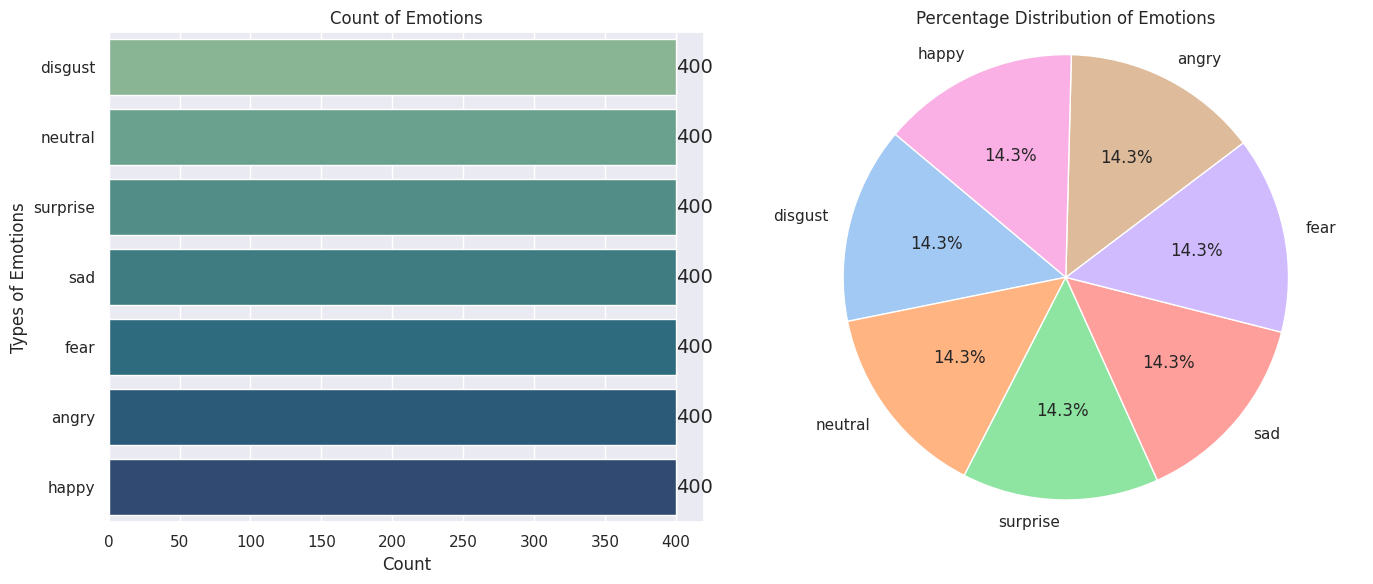

In [22]:
## Visualizing the Tess Data

vizualise_emotion(tess_df)

In [23]:
common_df = pd.concat([crema_df, ravdees_df, savee_df, tess_df], ignore_index=True, axis=0)
common_df.shape

(12162, 2)

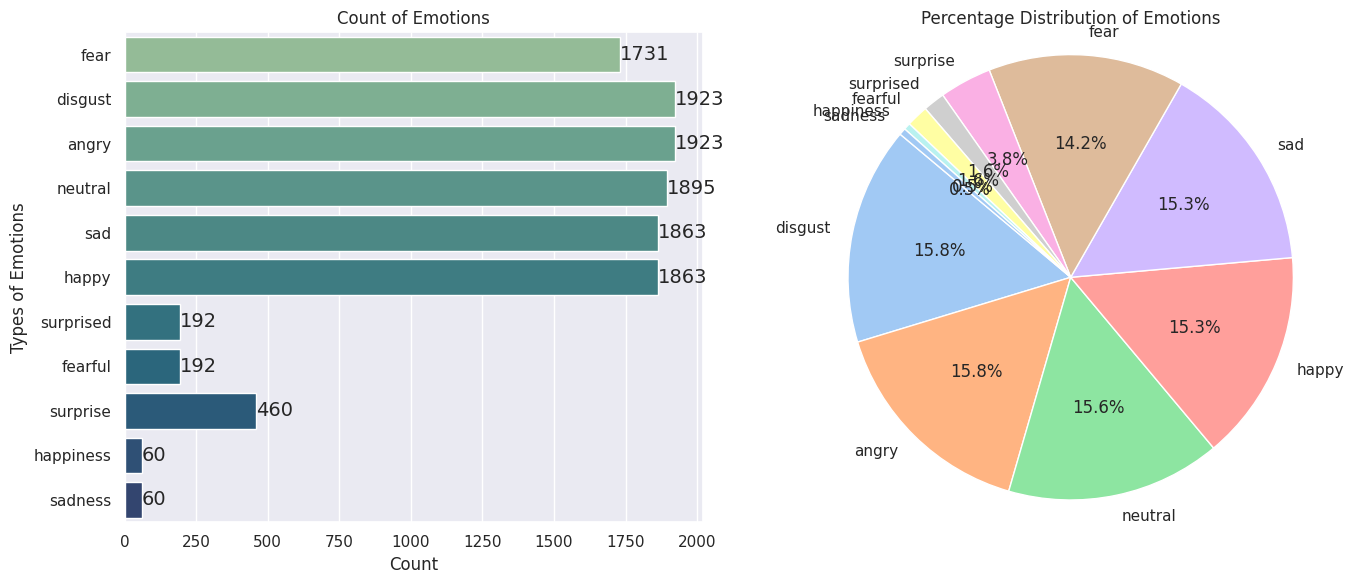

In [24]:
## Visualizing the whole data

vizualise_emotion(common_df)

In [25]:
## We have some extra category, which must be replaced

## fearful --> fear, surprised --> surprise, happiness --> happy and sadness --> sad
common_df['emotion'] = common_df['emotion'].replace(to_replace=['fearful', 'surprised', 'happiness', 'sadness'],
                                                    value=['fear', 'surprise', 'happy', 'sad'])

In [26]:
## Again Visualizing the whole data

vizualise_emotion(common_df)

* **Waveplot**

  - Waveforms are essential representations of speech signals, capturing the pressure variations that travel through the air. However, when analyzing speech, we often need to focus on specific segments or phonemes within the signal. This is where the Short-Time Fourier Transform (STFT) becomes valuable.

**Quantization: audio-to-digital conversion**

The analog-to-digital conversion process is called quantization and it's very similar to the way cameras capture video. A video camera reconstructs a continuous moment in time by capturing thousands of consecutive images per second, called frames. The higher the frame rate, the smoother the movie. In digital audio, an anlog-to-digital converter captures thousands of audio samples per second at a specified sample rate and bit depth to reconstruct the original signal. The higher the sample rate and bit depth, the higher the audio resolution.

**Sample rate** is the number of samples per second that are taken of a waveform to create a discrete digital signal. The higher the sample rate, the more snapshots you capture of the audio signal. The audio sample rate is measured in kilohertz (kHz) and it determines the range of frequencies captured in digital audio. In most DAWs, you’ll find an adjustable sample rate in your audio preferences. This controls the sample rate for audio in your project.


If you’re recording music, a standard sample rate is **44.1 kHz or 44,100 samples per second**. This is the standard for most consumer audio, used for formats like CDs. 48 kHz is another common audio sample rate used for movies. The higher sample rate technically leads to more measurements per second and a closer recreation of the original audio, so 48kHz is often used in audio for video which usually calls for a big dynamic range.

In [27]:
## Creating the audio arrays for Waveplot & further modeling purpose

%%time
audio_arr = []

for i in common_df['path']:
    y, sr = librosa.load(i, sr=44100)
    audio_arr.append(y)

common_df['Arrays'] = audio_arr

CPU times: user 47.5 s, sys: 4.38 s, total: 51.9 s
Wall time: 56.1 s


In [28]:
## Checking the data
common_df.head(15)

path  emotion  \
0   /content/datasets/speech-emotion-recognition-e...     fear   
1   /content/datasets/speech-emotion-recognition-e...  disgust   
2   /content/datasets/speech-emotion-recognition-e...  disgust   
3   /content/datasets/speech-emotion-recognition-e...    angry   
4   /content/datasets/speech-emotion-recognition-e...  neutral   
5   /content/datasets/speech-emotion-recognition-e...      sad   
6   /content/datasets/speech-emotion-recognition-e...  disgust   
7   /content/datasets/speech-emotion-recognition-e...    happy   
8   /content/datasets/speech-emotion-recognition-e...    happy   
9   /content/datasets/speech-emotion-recognition-e...  disgust   
10  /content/datasets/speech-emotion-recognition-e...      sad   
11  /content/datasets/speech-emotion-recognition-e...      sad   
12  /content/datasets/speech-emotion-recognition-e...  neutral   
13  /content/datasets/speech-emotion-recognition-e...     fear   
14  /content/datasets/speech-emotion-recognition-e...  disgust   

                                               Arrays  
0   [0.0008361143, 0.0012511024, 0.0013327599, 0.0...  
1   [-0.004408479, -0.005702437, -0.0053578303, -0...  
2   [-0.001956844, -0.0023594846, -0.002115969, -0...  
3   [0.0065365527, 0.0088584, 0.008830123, 0.00839...  
4   [0.00017229797, 0.00022152584, 6.7952904e-05, ...  
5   [0.0014075959, 0.001803858, 0.0015285935, 0.00...  
6   [-0.00556847, -0.006844671, -0.0059905825, -0....  
7   [-0.0019305558, -0.0021976612, -0.0016099847, ...  
8   [-0.0016184091, -0.0021249584, -0.002269961, -...  
9   [-0.0038820268, -0.004660148, -0.0038454505, -...  
10  [0.003919, 0.005125583, 0.0048660813, 0.004594...  
11  [0.0013077912, 0.0017847165, 0.001854928, 0.00...  
12  [-0.0028064172, -0.0039285077, -0.0041288, -0....  
13  [0.010521026, 0.013166916, 0.011998258, 0.0112...  
14  [-0.0023672972, -0.0031974476, -0.0032147614, ...

In [29]:
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

## creationg function to vizualize the Wavepllot
def waveplot(df, idx, emotion):
  path_ = df[df['emotion'] == str(emotion)]['path'].reset_index().drop('index', axis=1)
  ## storing the arrays by filltering with their emotion
  arr_ = df[df['emotion'] == str(emotion)]['Arrays'].reset_index().drop('index', axis=1)

  # Extract the audio data from the array
  audio_data = arr_.iloc[idx][0]

  # Assuming the sample rate is the same for all audio files,
  # you might need to adjust this if it varies
  sample_rate = 44100
  plt.figure(figsize=(12, 4), dpi=200)
  plt.plot(audio_data, 'k')
  plt.xlabel('Sample', fontdict= font)
  plt.ylabel('Amplitude', fontdict= font)
  plt.title(f'WAVEFORM - {emotion.upper()}', fontdict= font)
  plt.show()
  print()
  return Audio(path_.iloc[idx][0])

## creationg function to vizualize the Waveplot between specific index
def waveplot_byIndex(idx, emotion,idx1,idx2):
  ## storing the arrays by filltering with their emotion
  arr_ = common_df[common_df['emotion'] == str(emotion)]['Arrays'].reset_index().drop('index', axis=1)

  # Extract the audio data from the array
  audio_data = arr_.iloc[idx][0]

  plt.figure(figsize=(12, 4), dpi=200)
  plt.plot(audio_data[idx1:idx2], 'k')
  plt.xlabel('Sample', fontdict= font)
  plt.ylabel('Amplitude', fontdict= font)
  plt.title(f'WAVEFORM - {emotion.upper()} {(idx1, idx2)}', fontdict= font)
  plt.show()
  print()

In [30]:
## Vizualizing & Playing the first waveplot with Emotion 'happy'
waveplot(common_df, 0, 'happy')

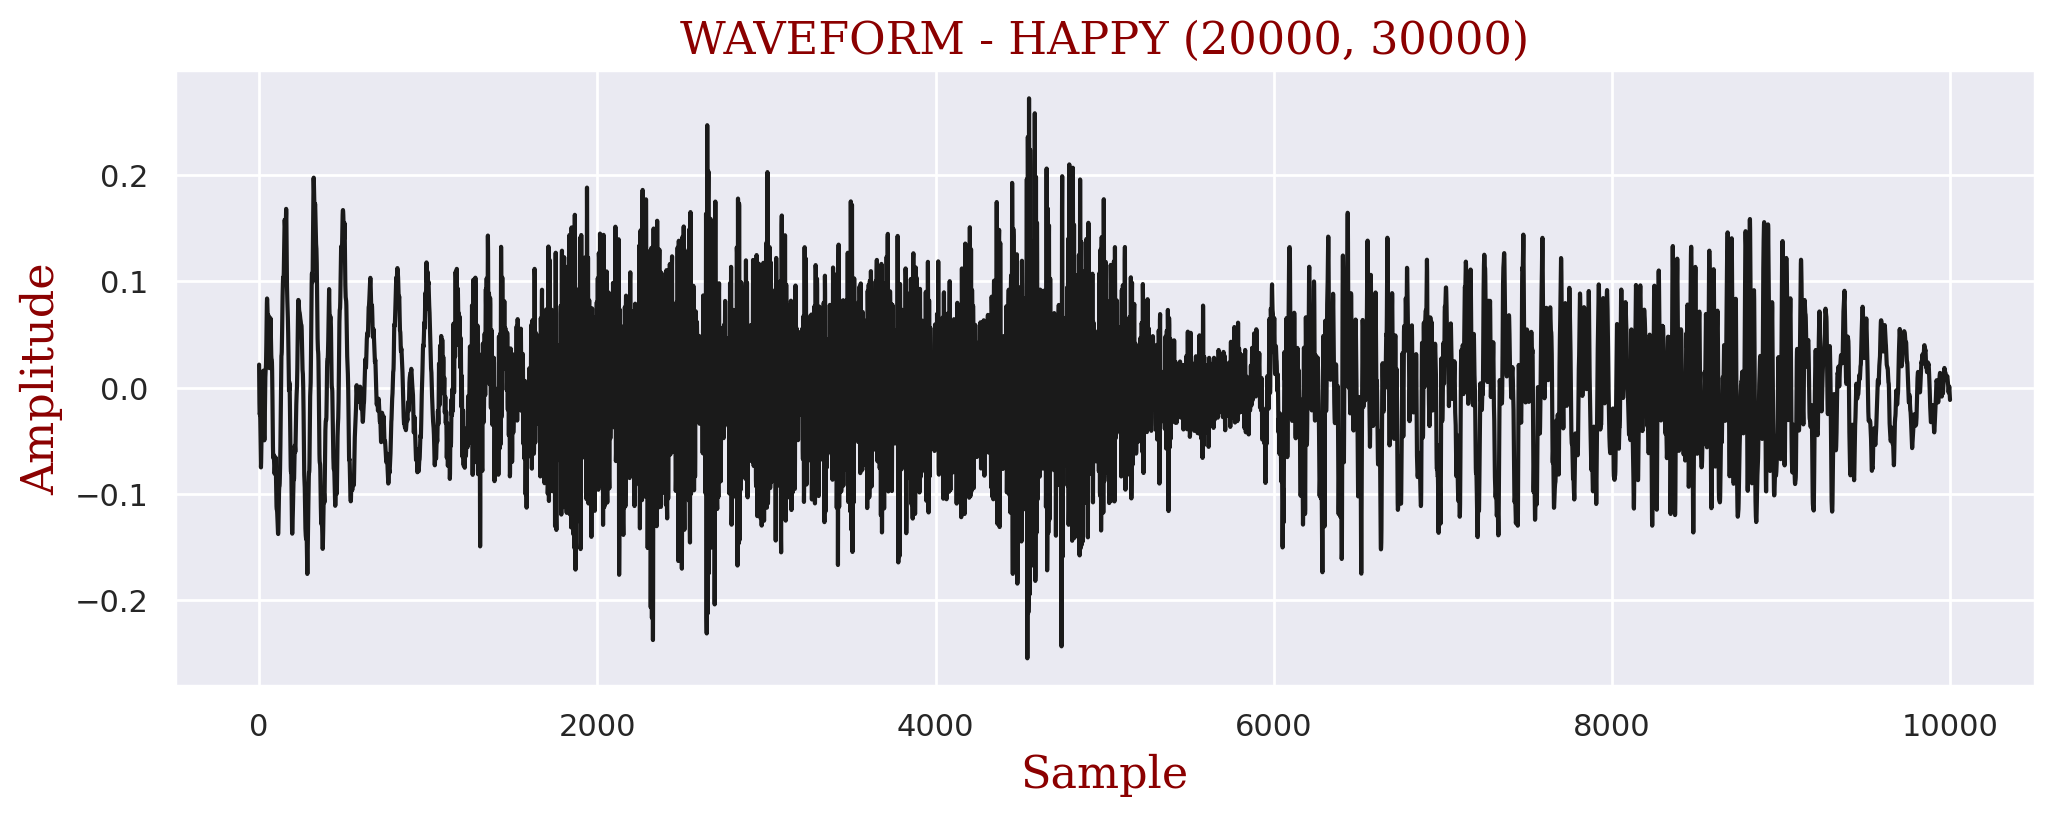

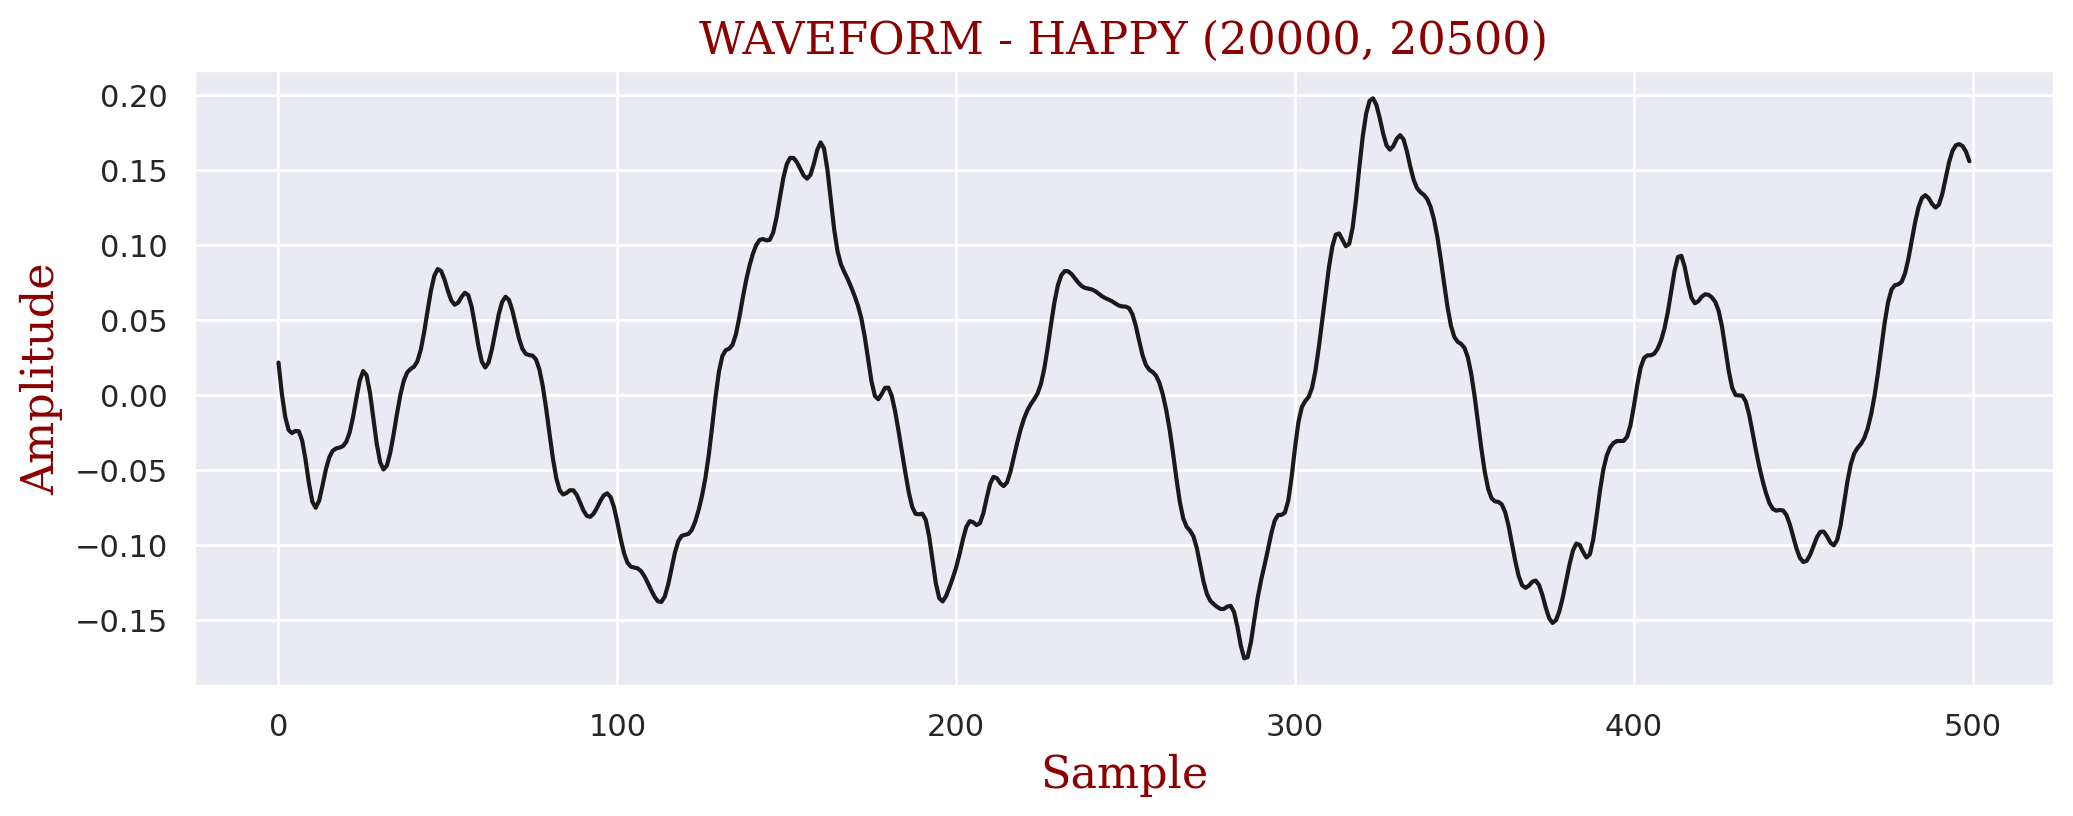

In [31]:
## Vizualizing the first waveplot within indexes 20000 - 30000
waveplot_byIndex(0, 'happy', 20000, 30000)

## Vizualizing the first waveplot within indexes 20000 - 20500
waveplot_byIndex(0, 'happy', 20000, 20500)

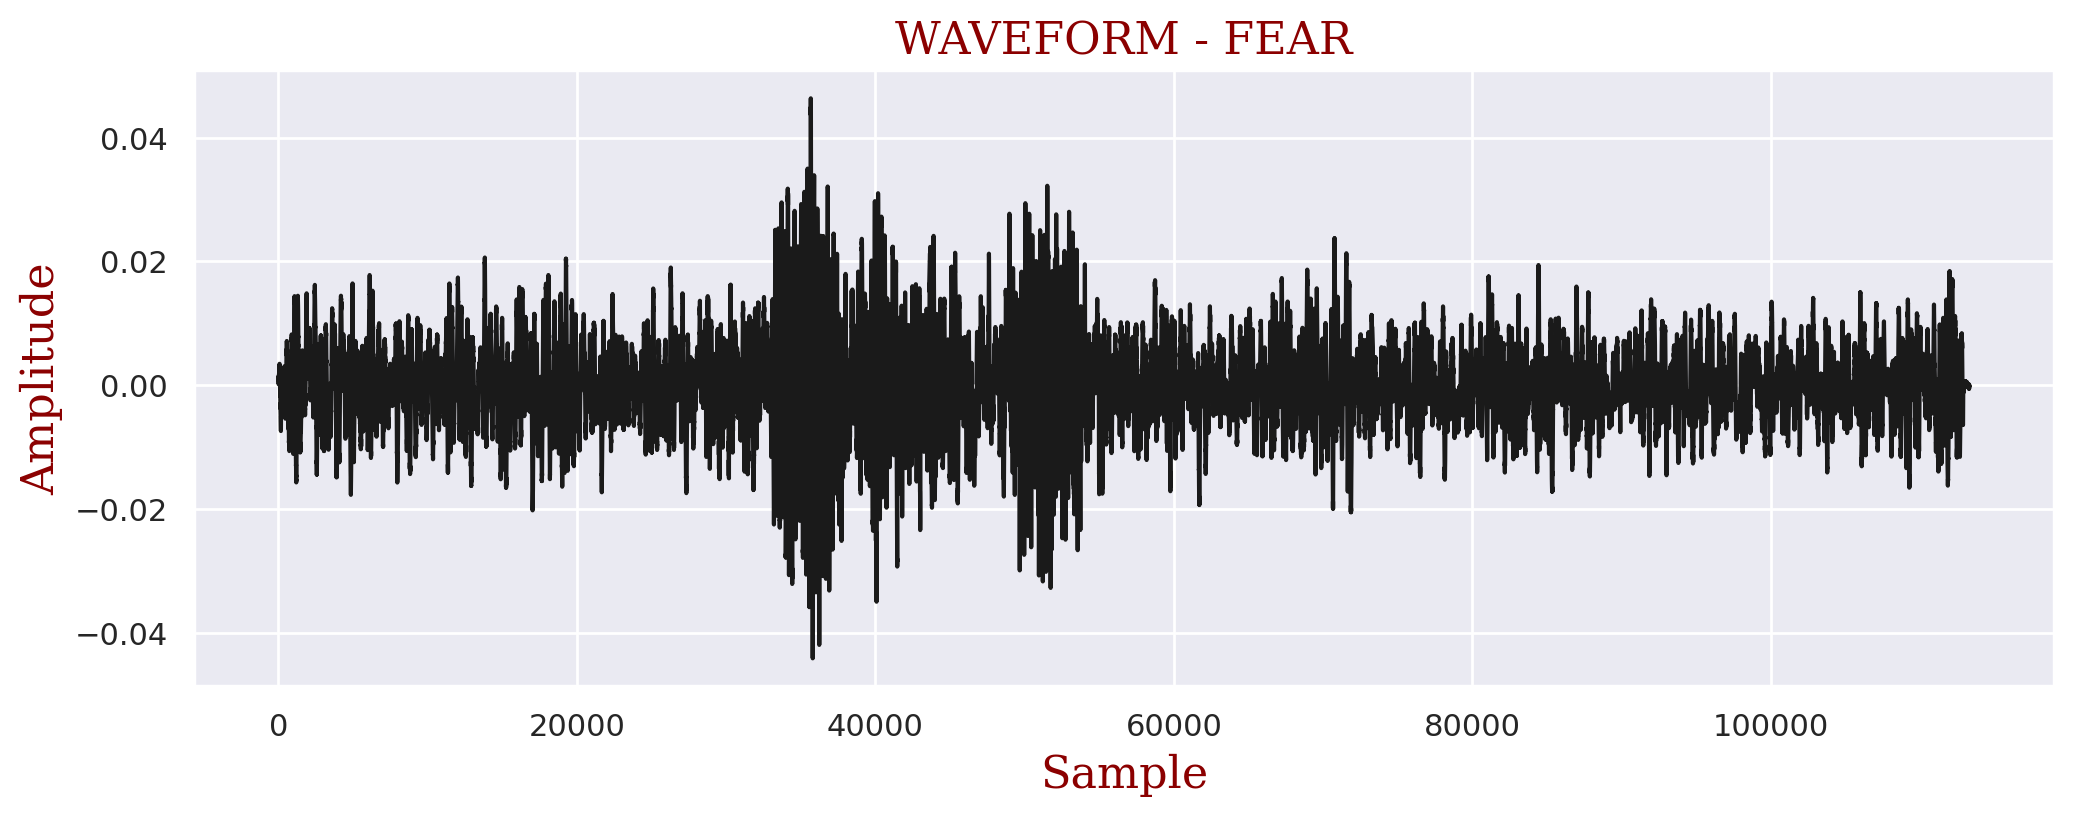

In [32]:
## Vizualizing & Playing the first waveplot with Emotion 'fear'
waveplot(common_df, 0, 'fear')

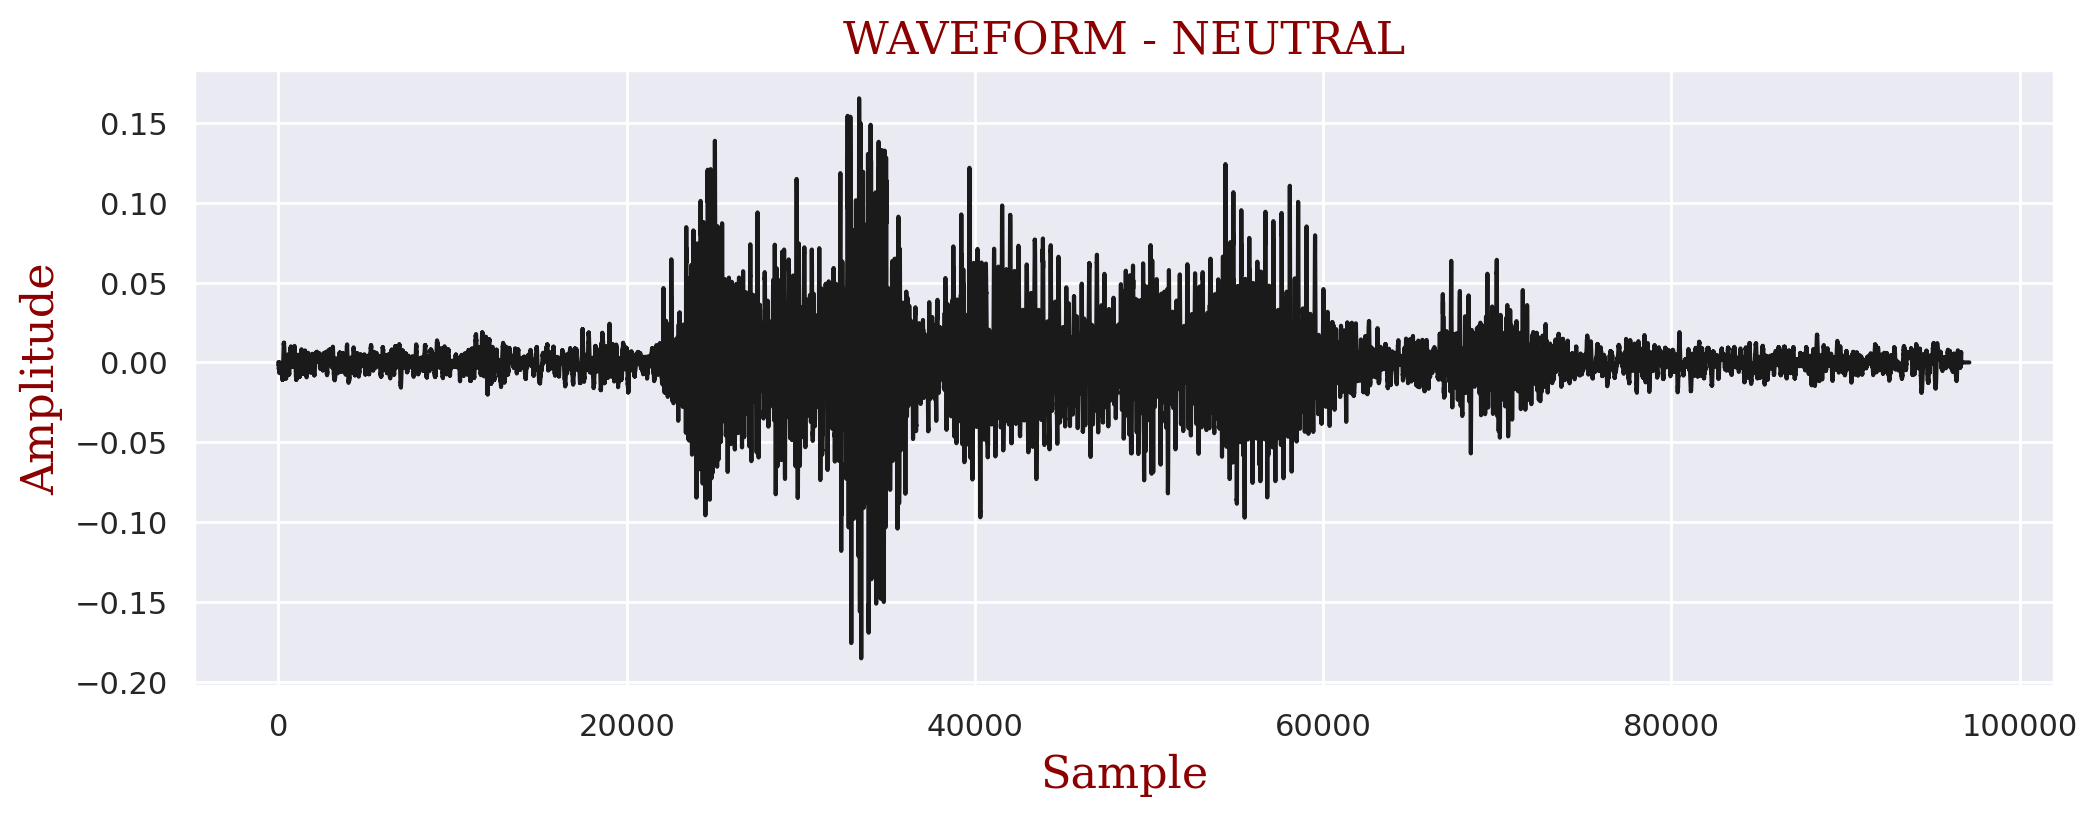

In [33]:
## Vizualizing & Playing the first waveplot with Emotion 'neutral'
waveplot(common_df, 0, 'neutral')

In [34]:
## Vizualizing & Playing the first waveplot with Emotion 'surprise'
waveplot(common_df, 0, 'surprise')

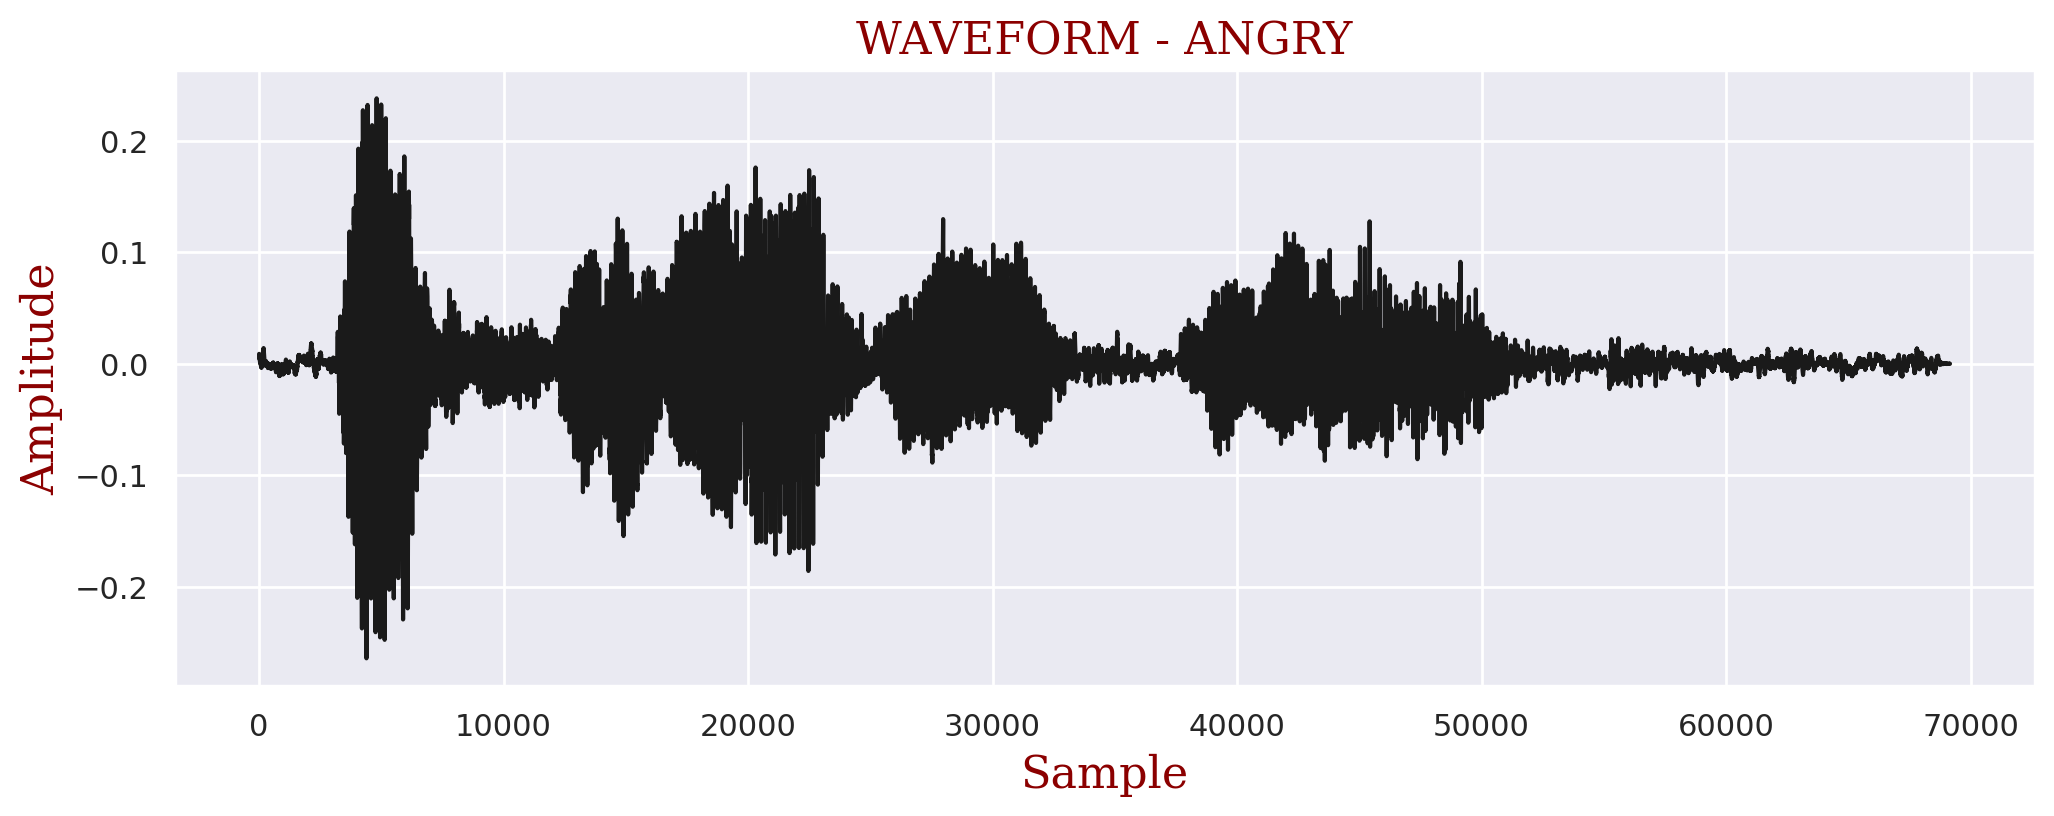

In [35]:
## Vizualizing & Playing the first waveplot with Emotion 'angry'
waveplot(common_df, 0, 'angry')

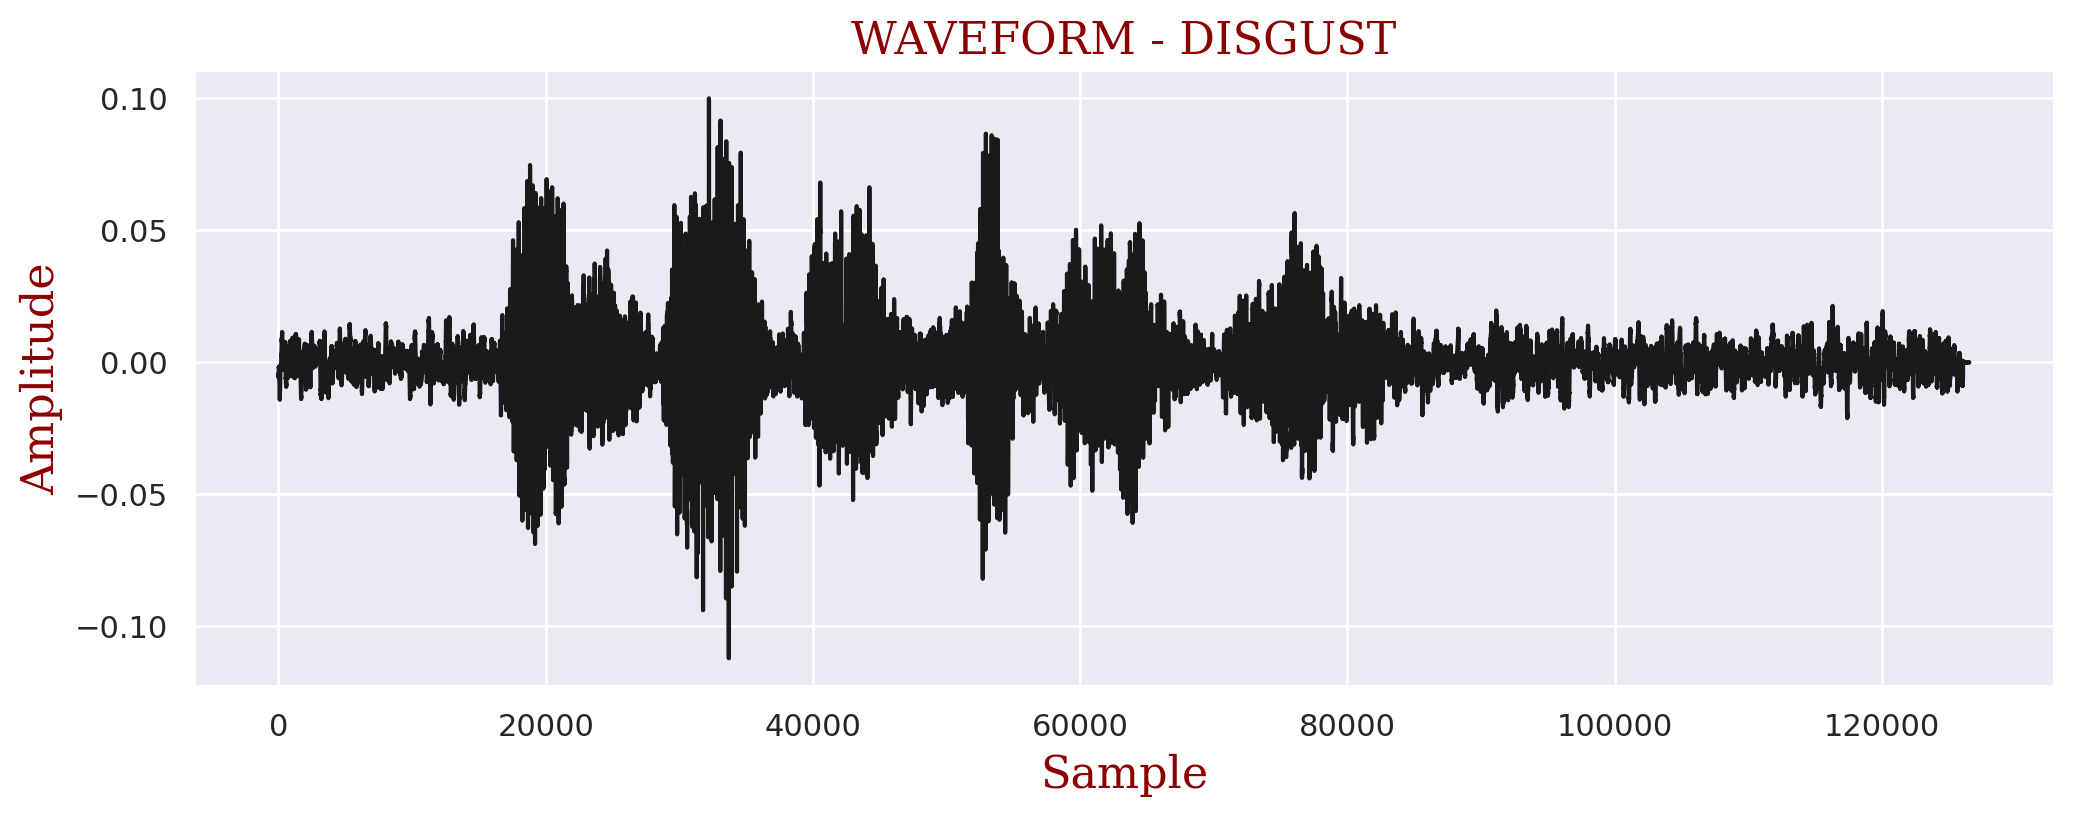

In [36]:
## Vizualizing & Playing the first waveplot with Emotion 'disgust'
waveplot(common_df, 0, 'disgust')

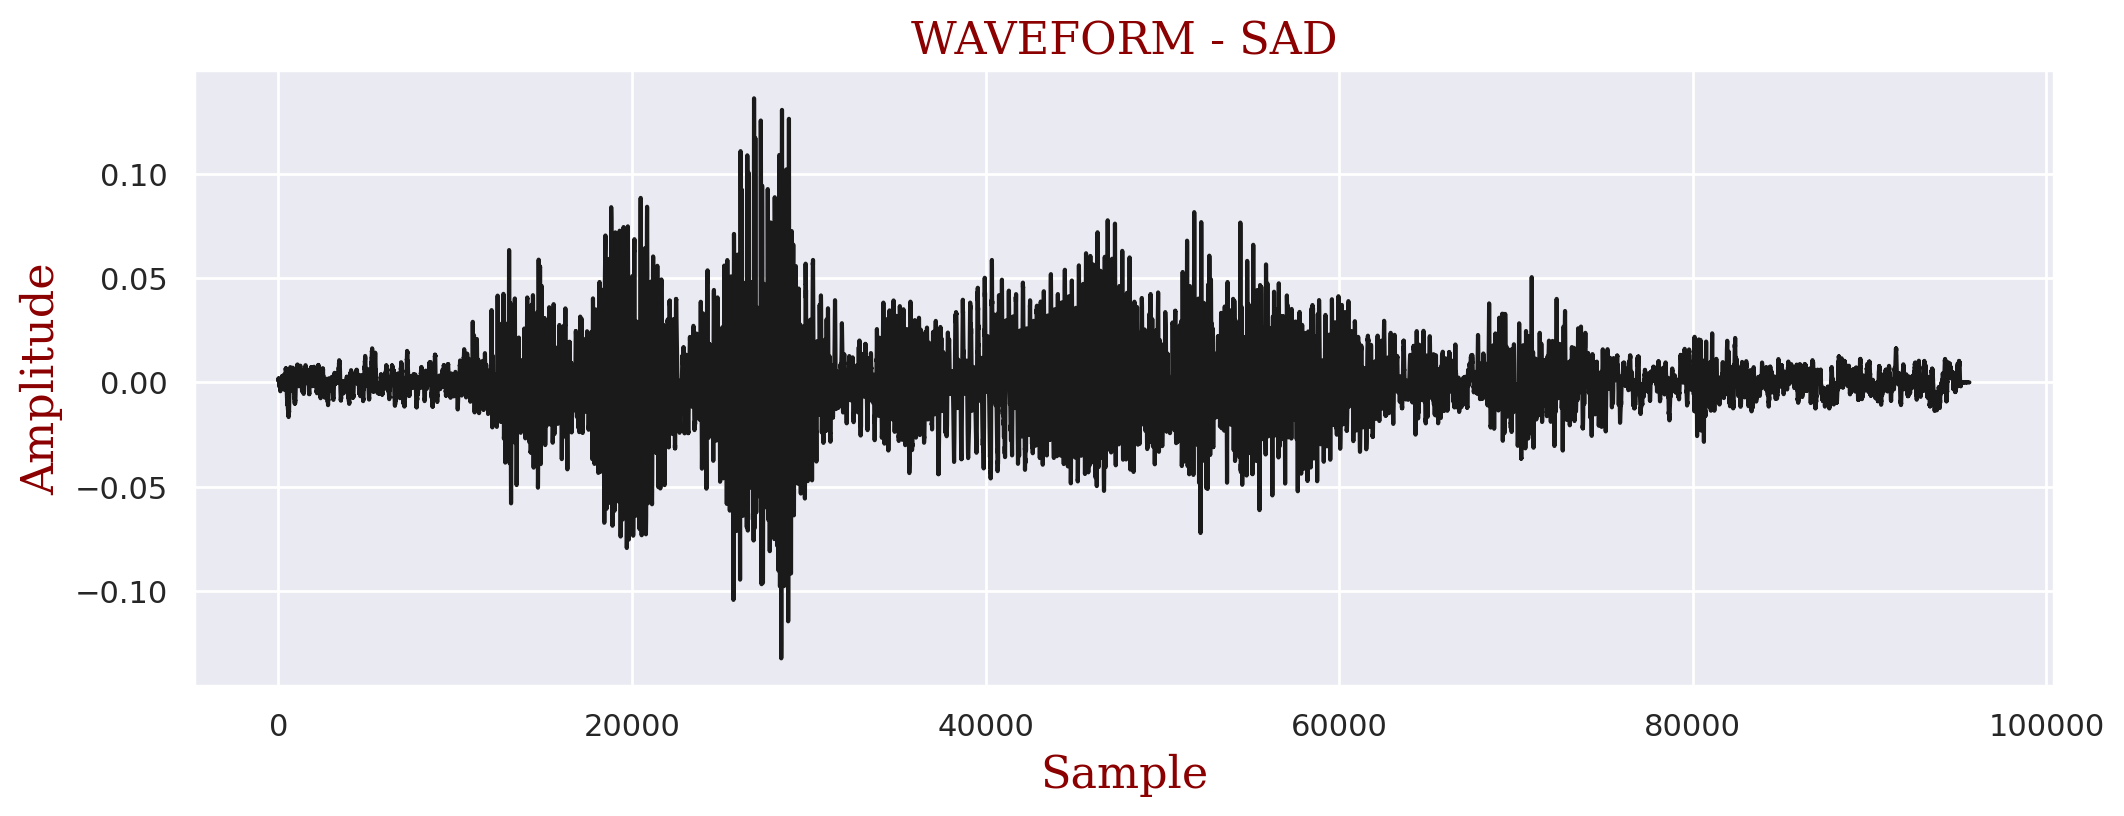

In [37]:
## Vizualizing & Playing the first waveplot with Emotion 'sad'
waveplot(common_df, 0, 'sad')

#### Augmentation (Noise, Stretch)

Data augmentation plays a crucial role in improving the performance of speech recognition models. Let’s explore two common audio augmentation techniques: noise injection and time stretching.Data augmentation plays a crucial role in improving the performance of speech recognition models. Let’s explore two common audio augmentation techniques: noise injection and time stretching.

Noise Injection: Adding noise to the audio data helps the model become more robust to real-world variations.Adding noise to the audio data helps the model become more robust to real-world variations.

Time Stretching: Time stretching alters the duration of an audio clip without changing its pitch.Time stretching alters the duration of an audio clip without changing its pitch.

In [38]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data



def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=0.8)


# taking any example and checking for techniques.
path = np.array(common_df.path)[1]
data, sample_rate = librosa.load(path)

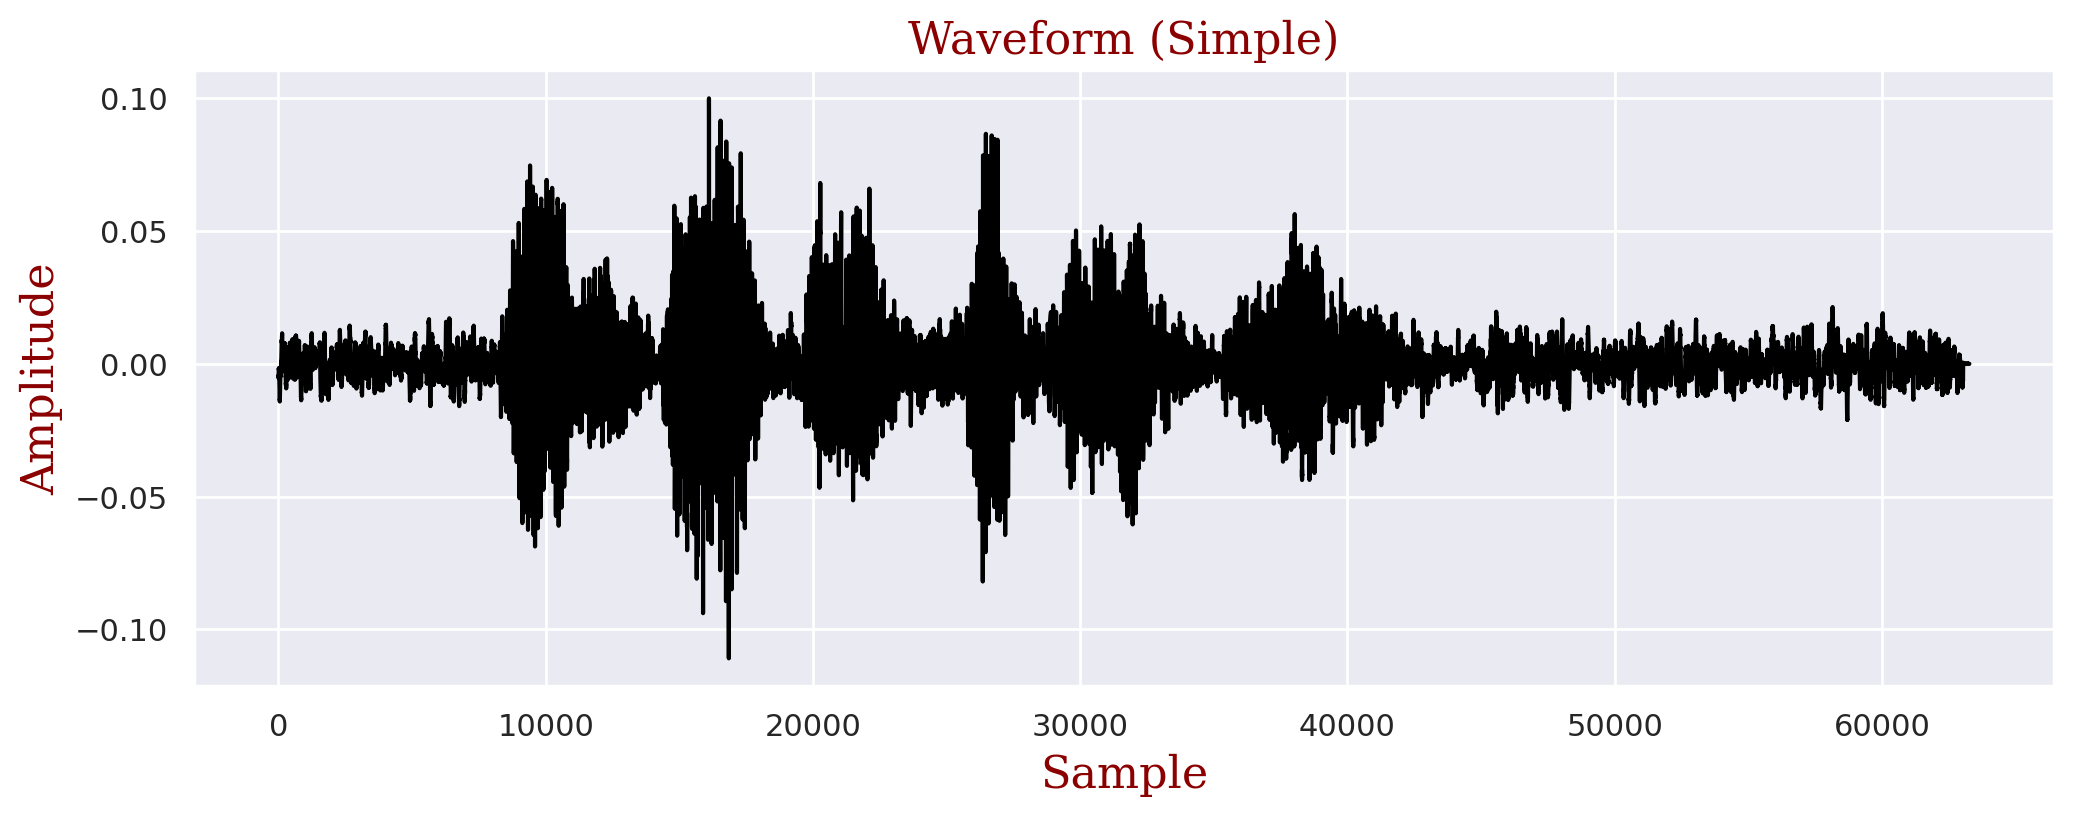

In [39]:
## Plotting simple Waveform

Simple_data = data
plt.figure(figsize=(12, 4), dpi=200)
plt.plot(Simple_data ,color='black')
plt.xlabel('Sample', fontdict= font)
plt.ylabel('Amplitude', fontdict= font)
plt.title('Waveform (Simple)', fontdict= font)
plt.show()

print()

Audio(Simple_data, rate=sample_rate)

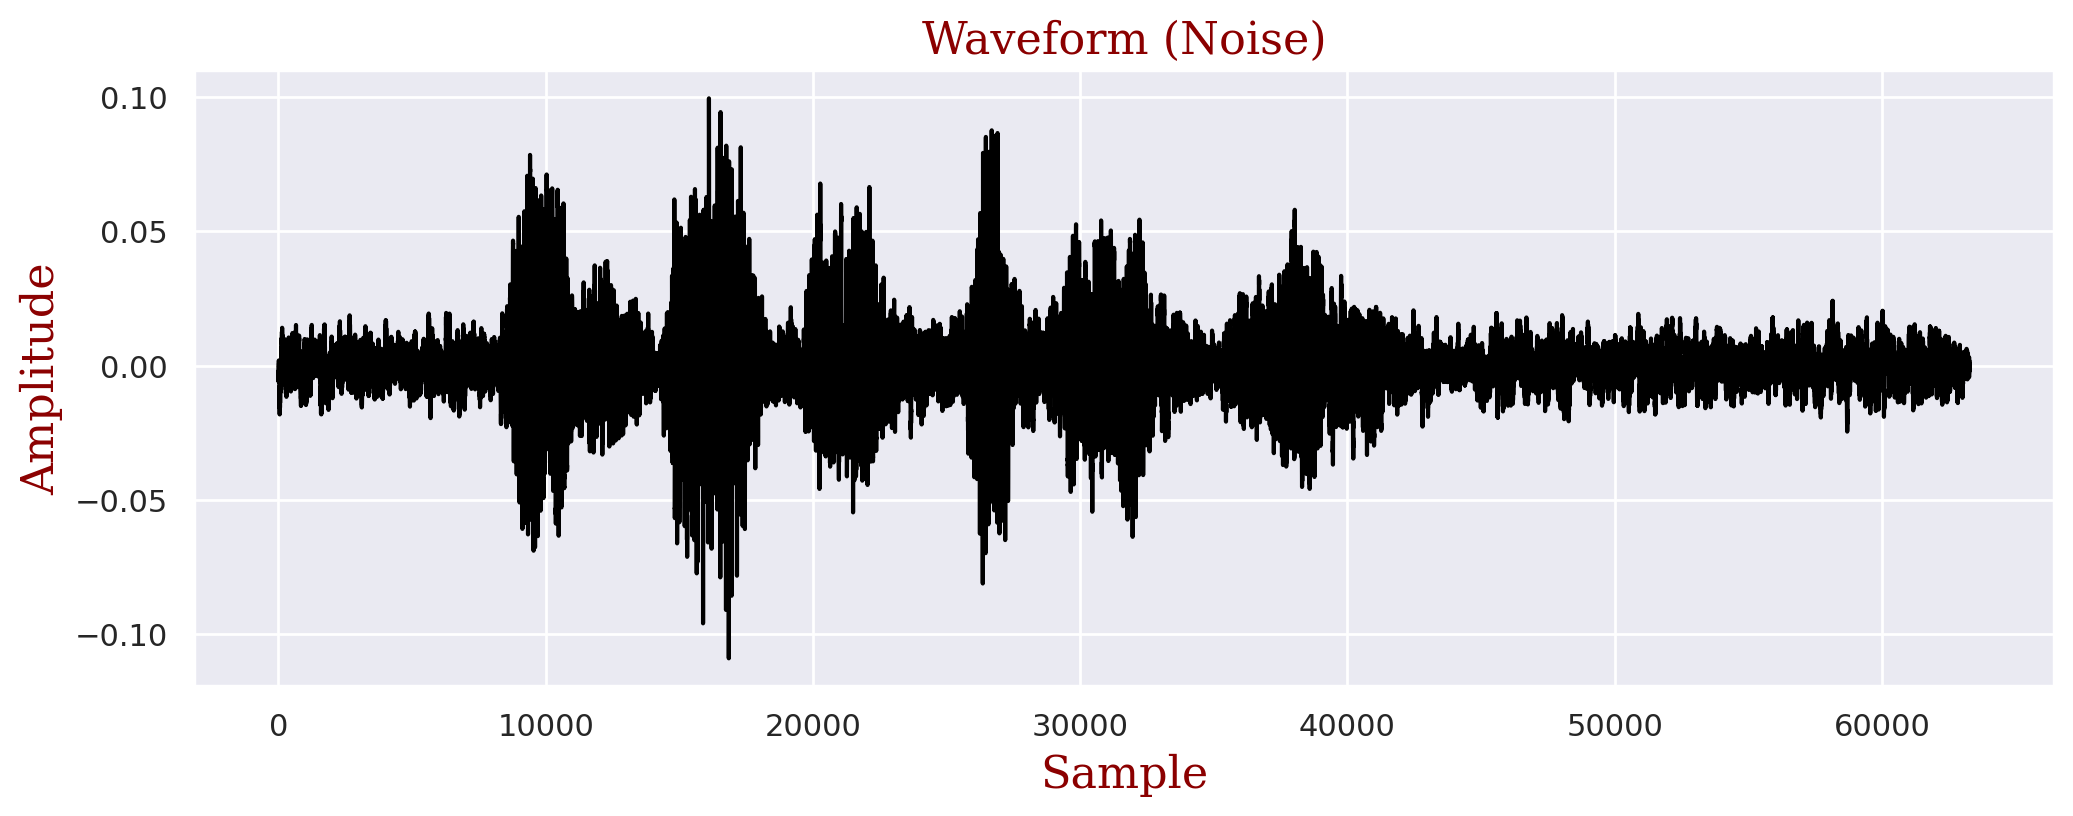

In [40]:
Noise_data = noise(data)
plt.figure(figsize=(12, 4), dpi=200)
plt.plot(Noise_data ,color='black')
plt.xlabel('Sample', fontdict= font)
plt.ylabel('Amplitude', fontdict= font)
plt.title('Waveform (Noise)', fontdict= font)
plt.show()

print()

Audio(Noise_data, rate=sample_rate)

## 3. Data PreParation

#### Only Crema

* In this project, I'm going to consider Crema dataset only.

In [41]:
print(crema_df.head())
print(crema_df.shape)

                                                path  emotion
0  /content/datasets/speech-emotion-recognition-e...     fear
1  /content/datasets/speech-emotion-recognition-e...  disgust
2  /content/datasets/speech-emotion-recognition-e...  disgust
3  /content/datasets/speech-emotion-recognition-e...    angry
4  /content/datasets/speech-emotion-recognition-e...  neutral
(7442, 2)


#### Extract mfcc

* Mel-frequency cepstral coefficients (MFCC) are a feature extraction technique widely used in speech and audio processing.

In [42]:
## Function to capture MEL array of length 50

def extract_mfcc(filename):
    y, sample_rate = librosa.load(filename, duration = 3, offset = 0.5)
    mfcc = np.mean(librosa.feature.mfcc(y = y, sr = sample_rate, n_mfcc = 50).T, axis = 0)
    return mfcc

In [43]:
mel_arr = extract_mfcc(crema_df['path'][0])
mel_arr

array([-4.7590833e+02,  1.4335733e+02,  1.6270252e+01,  6.7825226e+01,
       -1.3516059e+01,  4.1266380e+01, -1.6226311e+01,  1.6484200e+01,
       -1.1470356e+01,  6.7570062e+00,  8.4498096e-01, -4.5674496e+00,
        1.7294255e+00, -1.2728223e+01,  5.0519876e+00, -1.4423341e+01,
        3.3587363e+00, -1.1429716e+01, -3.5352234e-02, -7.1730680e+00,
       -1.8562069e+00, -4.5587116e-01, -4.0050578e+00,  4.8916106e+00,
       -4.9944277e+00,  7.3369799e+00, -3.0228240e+00,  4.8319530e+00,
       -1.9574363e+00,  9.5266080e-01, -1.9740541e+00,  6.6193879e-01,
        5.2795148e+00,  5.0062245e-01,  6.9237847e+00,  7.2432689e-02,
        5.3408222e+00, -1.8993980e+00,  2.2171376e+00, -1.9268931e+00,
        1.0958681e+00,  1.4689708e+00, -1.3229744e+00,  3.3344322e-01,
       -4.9207125e+00,  6.2396377e-01, -2.4669440e+00,  1.7928632e+00,
       -2.6306310e+00,  1.1679760e+00], dtype=float32)

In [44]:
len(mel_arr)

50

In [45]:
## Creating MEL-Frequency array

%%time
X_mfcc = crema_df['path'].apply(lambda x: extract_mfcc(x))

CPU times: user 1min 25s, sys: 1min 7s, total: 2min 33s
Wall time: 1min 37s


#### Array and Dimention

In speech recognition, the concept of expanding dimensions typically refers to increasing the feature space of input data. Array, speech signals are continuous waveforms.

In [46]:
## independent features (excluding target variable)
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(7442, 50)

In [47]:
## input split
X = np.expand_dims(X, -1)
X.shape

(7442, 50, 1)

In [48]:
## dependent variables (only target variable)

enc = OneHotEncoder()
y = enc.fit_transform(crema_df[['emotion']])
y = y.toarray()

## 4. LSTM Model

#### Structure of Model

* You can see the structure of LSTM in the cell below. Categorical_crossentropy for loss evaluation, ADAM as optimizer, validation split = 0.2 all of the Crema dataset, number of epochs = 500 and batchsize is 64.

In [49]:
model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(50,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(6, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 6)                 3

In [55]:
checkpoint_filepath = '/content/best_model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1)

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler_callback = LearningRateScheduler(scheduler)

history = model.fit(X, y, validation_split=0.2, epochs=500, batch_size=64)

Epoch 1/500
94/94 [==============================] - 1s 10ms/step - loss: 0.0630 - accuracy: 0.9822 - val_loss: 4.4330 - val_accuracy: 0.4271
Epoch 2/500
94/94 [==============================] - 1s 10ms/step - loss: 0.0611 - accuracy: 0.9827 - val_loss: 4.4476 - val_accuracy: 0.4043
Epoch 3/500
94/94 [==============================] - 1s 10ms/step - loss: 0.0474 - accuracy: 0.9864 - val_loss: 4.8619 - val_accuracy: 0.4050
Epoch 4/500
94/94 [==============================] - 1s 9ms/step - loss: 0.0690 - accuracy: 0.9797 - val_loss: 4.4243 - val_accuracy: 0.4003
Epoch 5/500
94/94 [==============================] - 1s 7ms/step - loss: 0.0369 - accuracy: 0.9866 - val_loss: 4.8301 - val_accuracy: 0.3956
Epoch 6/500
94/94 [==============================] - 1s 8ms/step - loss: 0.0260 - accuracy: 0.9933 - val_loss: 4.9198 - val_accuracy: 0.4036
Epoch 7/500
94/94 [==============================] - 1s 7ms/step - loss: 0.0405 - accuracy: 0.9881 - val_loss: 4.8741 - val_accuracy: 0.4090
Epoch 8/50

## 5. Evaluation

The accuracy and loss of model can be seen in the cells below.

### Accuracy over Epochs

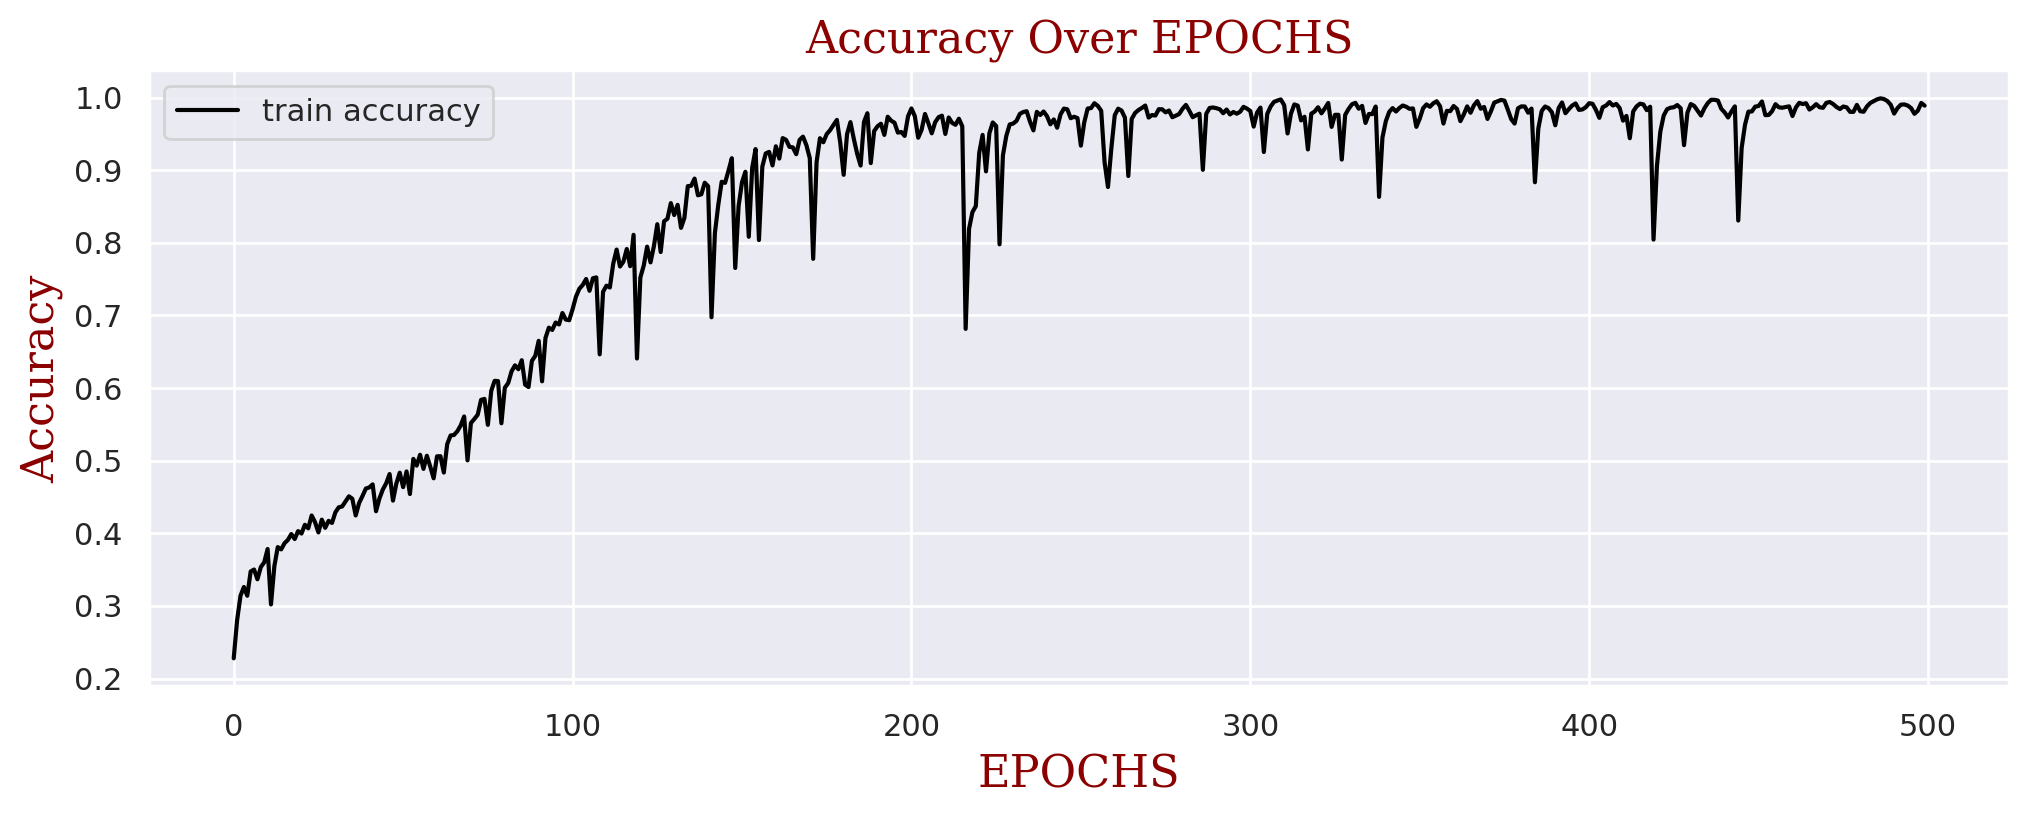

In [53]:
epochs = list(range(500))
acc = history.history['accuracy']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(epochs, acc, label='train accuracy', color='black')
plt.xlabel('EPOCHS', fontdict= font)
plt.ylabel('Accuracy', fontdict= font)
plt.title('Accuracy Over EPOCHS', fontdict= font)
plt.legend()
plt.show()

### Loss over Epochs

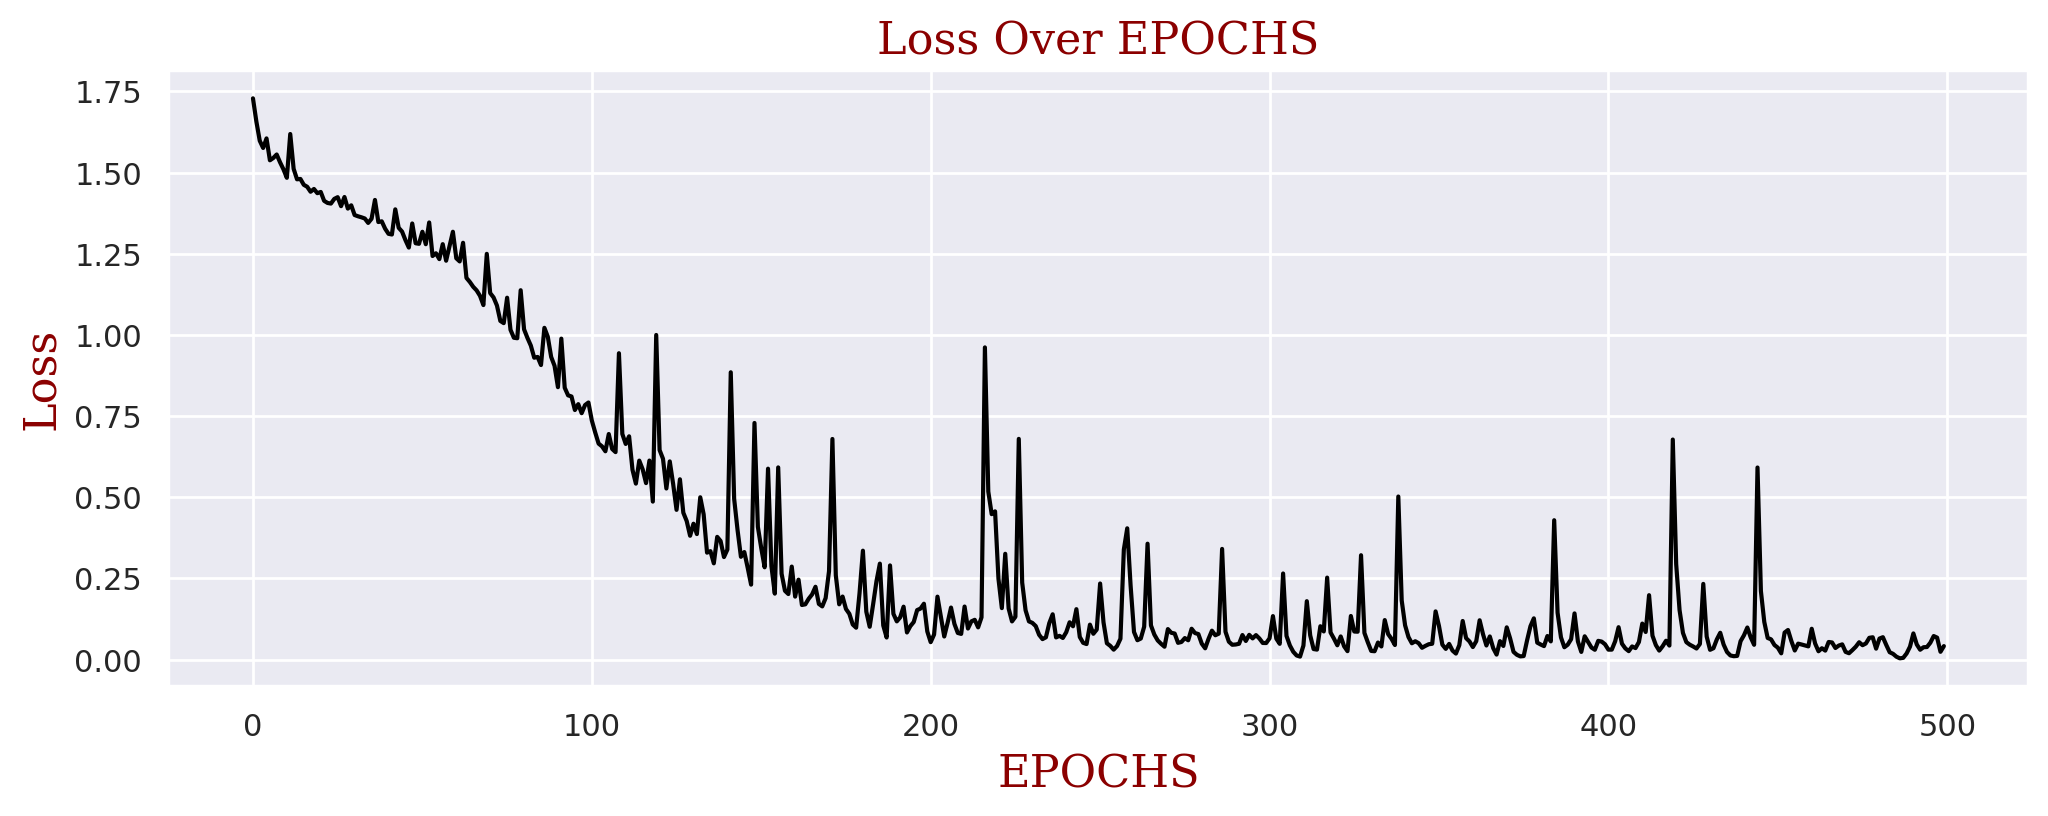

In [54]:
loss = history.history['loss']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(epochs, loss, label='train loss', color='black')
plt.xlabel('EPOCHS', fontdict= font)
plt.ylabel('Loss', fontdict= font)
plt.title('Loss Over EPOCHS', fontdict= font)
plt.show()